In [1]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import minmax_scale
import cv2
import os
import shutil

import json
import random
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
%matplotlib inline

print(tf.__version__)
print(f'TensorFlow built with cuda? {tf.test.is_built_with_cuda()}')
print(f'TensorFlow built with GPU support? {tf.test.is_built_with_gpu_support()}')

2024-07-09 18:03:42.967798: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-09 18:03:42.995686: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 18:03:42.995714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 18:03:42.996695: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-09 18:03:43.001217: I tensorflow/core/platform/cpu_feature_gua

2.16.2
TensorFlow built with cuda? True
TensorFlow built with GPU support? True


In [2]:
gpus = tf.config.list_physical_devices('GPU')
gpus

2024-07-09 18:03:44.859861: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-09 18:03:44.888231: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-09 18:03:44.888488: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
base_dir = './images/overlap'

images_dir ='./images/overlap/tiles'
masks_dir = './images/overlap/masks'

images_listdir = [img for img in os.listdir(images_dir) if img.endswith('jpg')]
masks_listdir = [img for img in os.listdir(masks_dir) if img.endswith('jpg')]

print(len(images_listdir))
print(len(masks_listdir))

521
521


In [4]:
random_images = np.random.choice(images_listdir, size = 9, replace = False)

In [5]:
IMG_SIZE = 512

def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

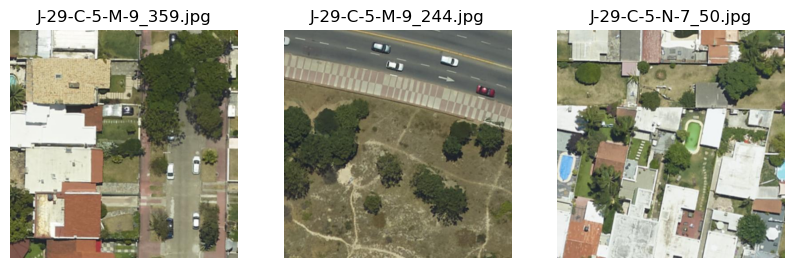

In [6]:
rows = 1
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (10, 10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        input_path = f"{images_dir}/{random_images[i]}"
        img = read_image(input_path)
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

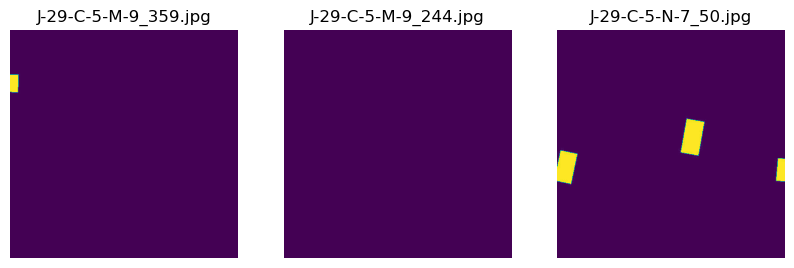

In [7]:
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        file=random_images[i]
        if os.path.exists(os.path.join(masks_dir,file)):
            img = read_image(f"{masks_dir}/{file}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax.set_title(f"{random_images[i]}")
            ax.imshow(img)
            ax.axis('off')
        else:
            print('not exist')

In [8]:
MASKS = np.zeros((1, IMG_SIZE, IMG_SIZE, 1), dtype=bool)
IMAGES = np.zeros((1, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

for img_file, mask_file in zip(images_listdir, masks_listdir):
    fpath = f'images/overlap/tiles/{img_file}'
    image = read_image(fpath)
    image_ex = np.expand_dims(image, axis=0)
    IMAGES = np.vstack([IMAGES, image_ex])

    fpath = f'images/overlap/masks/{mask_file}'
    mask = read_image(fpath)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = mask.reshape(IMG_SIZE, IMG_SIZE, 1)
    mask_ex = np.expand_dims(mask, axis=0)
    MASKS = np.vstack([MASKS, mask_ex])

In [9]:
images=np.array(IMAGES)
masks=np.array(MASKS)
print('Train')
print(images.shape, masks.shape)

Train
(522, 512, 512, 3) (522, 512, 512, 1)


In [10]:
images_train, images_test, masks_train, masks_test = train_test_split(
    images, masks, test_size=0.2, random_state=42)

In [11]:
for i in [images_train, images_test, masks_train, masks_test]:
    print(len(i))

417
105
417
105


In [12]:
# from tensorflow.keras import backend as K
# from tensorflow.keras.losses import binary_crossentropy
# from tensorflow.keras.optimizers import Adam

from tensorflow import keras

def iou_coeff(y_true, y_pred):
    # Calcula la intersección entre el y_true y y_pred
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    # Calcula la unión
    union = K.sum(y_true, -1) + K.sum(y_pred, -1) - intersection
    # Calcula el coeficiente de IoU
    iou = (intersection + K.epsilon()) / (union + K.epsilon())
    return iou

def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    return conv

def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2,2))(skip)
    return skip, pool

def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

def Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)

    bridge = conv_block(pool3, 512)

    decode2 = decoder_block(bridge, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decode4)
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

In [13]:
unet_model = Unet((IMG_SIZE, IMG_SIZE, 3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy')
unet_model.summary()

2024-07-09 18:04:47.472955: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-09 18:04:47.473209: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-09 18:04:47.473328: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ conv2d_4[0][0]  

 Total params: 7,708,609 (29.41 MB)

 Trainable params: 7,702,977 (29.38 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [14]:
unet_result = unet_model.fit(
    images_train, masks_train,
    validation_split = 0.2, batch_size = 1, epochs = 20)

Epoch 1/20


I0000 00:00:1720559098.354644   25374 service.cc:145] XLA service 0x769f98002160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720559098.354669   25374 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 with Max-Q Design, Compute Capability 7.5
2024-07-09 18:04:58.496896: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-09 18:04:59.059670: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-07-09 18:05:04.586497: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-09 18:05:06.222973: W external/local_tsl/tsl/framework/bfc_a

333/333 ━━━━━━━━━━━━━━━━━━━━ 158s 376ms/step - loss: -55.7922 - val_loss: -3086.3789
Epoch 2/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 125s 377ms/step - loss: -184.7694 - val_loss: -3677.6890
Epoch 3/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 126s 379ms/step - loss: -314.5255 - val_loss: -4615.5444
Epoch 4/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 126s 379ms/step - loss: -532.6837 - val_loss: -1019.4572
Epoch 5/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 126s 379ms/step - loss: -821.2919 - val_loss: -4888.0024
Epoch 6/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 126s 380ms/step - loss: -1166.5250 - val_loss: -6031.2549
Epoch 7/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 126s 380ms/step - loss: -1372.6066 - val_loss: -7834.9429
Epoch 8/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 127s 380ms/step - loss: -1862.5521 - val_loss: -7671.9180
Epoch 9/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 126s 380ms/step - loss: -2118.8125 - val_loss: -5043.2271
Epoch 10/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 127s 380ms/step - loss: -2865.5525 - val_loss: -7325.0952
Epoch 11/20
333/333 ━━━━━━━━━━━━━━━━

In [15]:
unet_model.save('./modelos/unet_512_20epochs_cpu.keras')

In [16]:
import keras

unet_model = keras.saving.load_model('./modelos/unet_512_20epochs_cpu.keras')

In [17]:
loss, acc = unet_model.evaluate(images_test, masks_test, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))


2024-07-09 19:03:36.325719: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at xla_ops.cc:580 : UNKNOWN: Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.45 = (f32[32,64,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,512,512]{3,2,1,0} %transpose.38, f32[64,3,3,3]{3,2,1,0} %transpose.39, f32[64]{0} %arg3.4), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="U-Net_1/conv2d_1/convolution" source_file="/home/guillermo/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/framework/ops.py" source_line=1177}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0}}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2164260864 bytes.

To ignore this failure and try to u

UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/home/guillermo/miniconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/guillermo/miniconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/guillermo/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/guillermo/miniconda3/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/guillermo/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/home/guillermo/miniconda3/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/guillermo/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/guillermo/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/home/guillermo/miniconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/guillermo/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/home/guillermo/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/home/guillermo/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/home/guillermo/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/home/guillermo/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/home/guillermo/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/guillermo/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/home/guillermo/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/home/guillermo/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/guillermo/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/home/guillermo/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/home/guillermo/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/tmp/ipykernel_24800/813885908.py", line 1, in <module>

  File "/home/guillermo/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/guillermo/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 429, in evaluate

  File "/home/guillermo/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 165, in one_step_on_iterator

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.45 = (f32[32,64,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,512,512]{3,2,1,0} %transpose.38, f32[64,3,3,3]{3,2,1,0} %transpose.39, f32[64]{0} %arg3.4), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="U-Net_1/conv2d_1/convolution" source_file="/home/guillermo/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/framework/ops.py" source_line=1177}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0}}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2164260864 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_64359]